In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import sys  
sys.path.insert(0, '../../db_test')
from db_test import *

area = 'DK2'
# areas = ['DK1','DK2']
files = ['consumption','price','wind']


data_dir = "../../../data/data_sanitized/"
forecast_dir = '../../../data/forecasts/wind/'

data = {}
for file in files:
    data[file] = {}
    data[file][area] = pd.read_csv(data_dir + file+"_"+ area+".csv")

models_variables = {'consumption':{
    'nordpool_prognosis': 'C1',
    "['dayofweek', 'consumption_prognosis']":'C2',
    "['dayofweek', 'consumption_prognosis', 'prev_day1', 'prev_day2', 'prev_day7']":'C3',
    "['dayofweek', 'consumption_prognosis', 'prev_day1', 'prev_day2', 'prev_day7', 'wind_prognosis']":'C4'
},'wind':{
    'nordpool_prognosis': 'W1',
    "['dayofweek', 'wind_prognosis']": 'W2',
    "['dayofweek', 'wind_prognosis', 'prev_day1', 'prev_day2', 'prev_day7']": 'W3',
    "['dayofweek', 'wind_prognosis', 'prev_day1', 'prev_day2', 'prev_day7', 'consumption_prognosis']": 'W4'
},'price':{
    "['dayofweek']": 'P1',
    "['dayofweek', 'prev_day1', 'prev_day2', 'prev_day7']": 'P2',
    "['dayofweek', 'prev_day1', 'prev_day2', 'prev_day7', 'min_day', 'max_day', 'last_val_day']": 'P3',
    "['dayofweek', 'prev_day1', 'prev_day2', 'prev_day7', 'min_day', 'max_day', 'last_val_day', 'consumption_prognosis', 'wind_prognosis']": 'P4',
    "['dayofweek', 'prev_day1', 'prev_day2', 'prev_day7', 'min_day', 'max_day', 'last_val_day', 'consumption_prognosis_for_price', 'wind_prognosis_for_price']": 'P5'
}}

models_to_test = {
    'consumption': {
        'DK1': [
            'C1.728',
            'C2.182',
            'C2.364',
            'C2.728',
            'C2.182.asinh',
            'C2.364.asinh',
            'C2.728.asinh',
            'C3.182',
            'C3.364',
            'C3.728',
            'C3.182.asinh',
            'C3.364.asinh',
            'C3.728.asinh',
            'C4.182',
            'C4.364',
            'C4.728',
            'C4.182.asinh',
            'C4.364.asinh',
            'C4.728.asinh'
        ],
        'DK2': [
            'C2.182',
            'C2.364',
            'C2.728',
            'C3.182',
            'C3.364',
            'C3.728',
            'C3.182.asinh',
            'C3.364.asinh',
            'C3.728.asinh',
            'C3.182.hp',
            'C3.364.hp',
            'C3.728.hp',
            'C4.182',
            'C4.364',
            'C4.728',
            'C4.364.asinh',
            'C4.728.asinh',
            'C4.182.hp',
            'C4.364.hp',
            'C4.728.hp',
        ]
    },
    'wind': {
        'DK1': [
            'W2.182.asinh-hp',
            'W2.364.asinh-hp',
            'W2.728.asinh-hp',
            'W2.182.hp',
            'W2.364.hp',
            'W2.728.hp',
            'W3.182.asinh-hp',
            'W3.364.asinh-hp',
            'W3.728.asinh-hp',
            'W3.182.hp',
            'W3.364.hp',
            'W3.728.hp',
            'W4.182.asinh-hp',
            'W4.364.asinh-hp',
            'W4.728.asinh-hp',
            'W4.182.hp',
            'W4.364.hp',
            'W4.728.hp'
        ],
        'DK2': [
            'W1.728',
            'W2.182',
            'W2.364',
            'W2.728',
            'W2.182.hp',
            'W2.364.hp',
            'W2.364.asinh',
            'W2.728.asinh',
            'W3.182',
            'W3.364',
            'W3.728',
            'W3.182.asinh',
            'W3.364.asinh',
            'W3.728.asinh',
            'W4.182',
            'W4.364',
            'W4.728',
            'W4.182.asinh',
            'W4.364.asinh',
            'W4.728.asinh',
        ]
    },
    'price': {
        'DK1': [
            'P4.182',
            'P4.728',
            'P4.182.asinh',
            'P4.364.asinh',
            'P4.728.asinh',
            'P4.182.hp',
            'P4.364.hp',
            'P4.728.hp',
            'P4.182.asinh-hp',
            'P4.364.asinh-hp',
            'P4.728.asinh-hp',
            'P5.182',
            'P5.728',
            'P5.182.asinh',
            'P5.728.asinh',
            'P5.182.hp',
            'P5.728.hp',
            'P5.182.asinh-hp',
            'P5.728.asinh-hp',
        ],
        'DK2': [
            'P4.182',
            'P4.364',
            'P4.728',
            'P4.182.asinh',
            'P4.364.asinh',
            'P4.728.asinh',
            'P4.182.hp',
            'P4.728.hp',
            'P4.182.asinh-hp',
            'P4.364.asinh-hp',
            'P4.728.asinh-hp',
            'P5.182',
            'P5.728',
            'P5.182.asinh',
            'P5.728.asinh',
            'P5.182.hp',
            'P5.728.hp',
            'P5.182.asinh-hp',
            'P5.364.asinh-hp',
            'P5.728.asinh-hp',
        ]
    }
}

def get_forecast_file(no):
    return pd.read_csv(forecast_dir + no +".csv")

flatten = lambda l: [item for sublist in l.values.tolist() for item in sublist]

In [35]:
forecasts_file = forecast_dir + 'files.txt'
forecasts = {}

with open(forecasts_file, 'r+') as f:
    lines = f.read().splitlines()
    if not lines:
        print('Empty file')
    for line in lines:
        cur_line = line.split('.', 1)
        if not cur_line[0] =='':
            no = cur_line[0]
            cur_line[1] =  cur_line[1].split('|')
            forecasts[no] = {"data":get_forecast_file(no),'file':cur_line[1][0],'area':cur_line[1][1],'window':cur_line[1][2],'start_date':cur_line[1][3],'last_date':cur_line[1][4], 'std_fn':cur_line[1][5], 'variables':cur_line[1][6]}

len(forecasts)

312

In [36]:
table = {"consumption":{},"wind":{},"price":{}}
forecasts_list = {}
for f in forecasts:
    fc = forecasts[f]
    model = fc['variables']
    
    if not fc['area'] == area:
        continue
    
    if fc['variables'] in models_variables[fc['file']]:
        model = models_variables[fc['file']][fc['variables']]
    fc['name'] = fc['start_date'] + '.' + fc['last_date'] + '.' + str(model) + ('.' + fc['std_fn'] if not fc['std_fn'] == 'None' else '')
    fc['name'] = str(model) + '.' + fc['window'] + ('.' + fc['std_fn'] if not fc['std_fn'] == 'None' else '')

    if not fc['name'] in models_to_test[fc['file']][fc['area']]:
        continue

    fc['start_date'] = fc['start_date'].replace('-','.')
    fc['last_date'] = fc['last_date'].replace('-','.')
    dates = fc['start_date'] + '-' + fc['last_date']
    
    
    if not fc['area'] in table[fc['file']]:
        table[fc['file']][fc['area']] = {}
    if not dates in table[fc['file']][fc['area']]:
        table[fc['file']][fc['area']][dates] = {}
    
    if not fc['name'] in table[fc['file']][fc['area']][dates]:
        table[fc['file']][fc['area']][dates][fc['name']] = {}
        
    fdm = table[fc['file']][fc['area']][dates][fc['name']]
    for model_tt in models_to_test[fc['file']][fc['area']]:
#         if fc['name'] == model_tt:
#             continue
#         if model_tt in table[fc['file']][fc['area']][dates]:
#             continue
        fdm[model_tt] = {"DM":0,"P-value":0}
    
    forecast_full_name = fc['file'] + '.' + fc['area'] + '.' + dates + '.' + model + '.' + fc['window'] + ('.' + fc['std_fn'] if not fc['std_fn'] == 'None' else '')
    forecasts_list[forecast_full_name] = fc['data']

print(len(forecasts_list))

80


In [37]:
from re import compile as re_compile
for file in table:
    for a in table[file]:
        for d in table[file][a]:
            for f1 in table[file][a][d]:
                forecast_name1 = file + '.' + a + '.' + d + '.' + f1
                first_index = forecasts_list[forecast_name1].iloc[0,0]
                last_index = forecasts_list[forecast_name1].iloc[-1,0]
                
                true_val = flatten(data[file][a].loc[first_index:last_index,'0':'23'])
            
                pred1_val = flatten(forecasts_list[forecast_name1].loc[:,'0':'23'])
                
                for f2 in table[file][a][d][f1]:
                    if f1 == f2:
                        continue
                    
                    forecast_name2 = file + '.' + a + '.' + d + '.' + f2
                    pred2_val = flatten(forecasts_list[forecast_name2].loc[:,'0':'23'])

                    if pred2_val == pred1_val:
                        continue
                    rt = dm_test(true_val,pred1_val,pred2_val,h = 1, crit="MAD")
                    
                    table[file][a][d][f1][f2]['DM'] = round(rt[0],3)
                    table[file][a][d][f1][f2]['P-value'] = round(rt[1],4)

In [38]:
def update_key(old_key,new_key,d):
    if isinstance(d,dict):
        if old_key in d:
            d[new_key] = d[old_key]
            del d[old_key]
        for key in d:
            updateKey(old_key,new_key,d[key])

update_key('C1.728','C1',table)
update_key('W1.728','W1',table)
table

def color_gray_zero(val):
    color = 'silver' if val == 0 else ''
    return 'background-color: %s' % color

In [50]:
df = pd.DataFrame.from_records(np.ones((1,1)))
df['Area'] = [area]
df['Dates'] = ['2019.01.01-2019.12.31']
file = 'wind'
df['Model 1'] = [models_to_test[file][area][0]]
df['Model 2'] = [models_to_test[file][area][1]]


df = df.groupby(['Area','Dates','Model 1','Model 2']).sum()
# df = df.rename(columns={0:1,1:3,2:4,3:5})


for area in table[file]:
    for dates in table[file][area]:
        for model1 in table[file][area][dates]:
                for model2 in table[file][area][dates][model1]:
                    DM = table[file][area][dates][model1][model2]['DM']
                    PV = table[file][area][dates][model1][model2]['P-value']
                    
                    insert = DM
                    if model1 == model2:
                        insert = 0
                    if PV > 0.05:
                        insert = 0
                    
                    df.loc[(area,dates,model1,model2),'DM'] = -insert
#                     df.loc[(area,dates,model1,model2),'DM'] = table[file][area][dates][model1][model2]['P-value']

                    
df = df.drop(columns=[0])
df = df.pivot_table(index=['Area','Dates','Model 1'], columns='Model 2', values='DM')
df.columns = [i.replace('.','<br>') for i in df.columns]
df = df.sort_index()
# df = df[df.index.get_level_values(1) == '2019.01.01-2019.12.31']
# df = df[df.index.get_level_values(1) == '2019.05.13-2020.05.12']
# df = df[df.index.get_level_values(1) == '2019.01.01-2020.05.12']
df = df[df.index.get_level_values(1) == '2020.01.01-2020.05.12']
pd.set_option('precision', 3)
cm = ListedColormap(sns.diverging_palette(133, 10, n=10))
display = df.style.background_gradient(cmap=cm.reversed(),vmax=15,vmin=-15)

display.applymap(color_gray_zero)

display

In [87]:
def color_gray_zero(val):
    color = 'silver' if val == 0 else ''
    return 'background-color: %s' % color

display.applymap(color_gray_zero)
display

In [20]:
import random

random.seed(123)
actual_lst = range(0,100)
pred2_lst = range(80,180)
pred1_lst = range(0,100)

actual_lst = random.sample(actual_lst,100)
pred1_lst = random.sample(pred1_lst,100)
pred2_lst = random.sample(pred2_lst,100)

rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="MAD")
print(rt)
rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="MSE")
print(rt)
rt = dm_test(actual_lst,pred1_lst,pred2_lst,h = 1, crit="poly", power=4)
print(rt)

dm_return(DM=-9.228367936305471, p_value=5.2733566900864244e-15)
dm_return(DM=-8.60656865528822, p_value=1.1839305042979687e-13)
dm_return(DM=-6.203866595889205, p_value=1.284969716752485e-08)


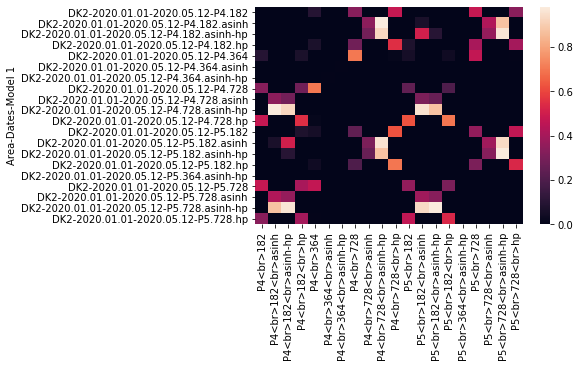

In [34]:
sns.palplot(sns.diverging_palette(220, 10))
